In [61]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
%matplotlib inline

# Connect to MongoDB

In [307]:
conn = pymongo.MongoClient()['steam']
cursor = conn['test'].find({})

In [308]:
df = pd.DataFrame(list(cursor))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 7 columns):
_id                656 non-null object
ban_status         656 non-null object
friends            656 non-null object
game_info          656 non-null object
profile_summary    656 non-null object
steamid            656 non-null object
user_info          656 non-null object
dtypes: object(7)
memory usage: 35.9+ KB


In [39]:
#games = df.copy()
#games = games[["steamid", "game_info"]]

# Unpack Columns Containing a Single Dictionary

In [12]:
def unpack(df, column, fillna=None):
    new_df = None
    if fillna is None:
        new_df = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems()))], axis=1)
        del new_df[column]
    else:
        new_df = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems())).fillna(fillna)], axis=1)
        del new_df[column]
    return new_df

#unpack(tf, 'nested', 0)

In [309]:
df = unpack(df, "user_info", fillna=None)

In [310]:
df = unpack(df, "ban_status", fillna=None)

In [259]:
df.head(1)

,_id,friends,game_info,profile_summary,steamid,avatarfull,commentpermission,communityvisibilitystate,gameextrainfo,gameid,...,primaryclanid,profilestate,realname,timecreated,CommunityBanned,DaysSinceLastBan,EconomyBan,NumberOfGameBans,NumberOfVACBans,VACBanned
0,570fc54763210f0e63d825fc,"[{u'steamid': u'76561197962935145', u'friend_s...","[{u'playtime_forever': 63, u'playtime_2weeks':...",No information given.,76561197981918203,https://steamcdn-a.akamaihd.net/steamcommunity...,NaN,3,NaN,NaN,...,103582791429521408,1.0,NaN,1.144367e+09,False,0,none,0,0,False


# Split up users based on public or private profiles

In [311]:
df2 = df.copy()
private_df = df2[df2["profile_summary"] == "private"]
public_df = df2[df2["profile_summary"] != "private"]

In [312]:
private_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 3 to 654
Data columns (total 28 columns):
_id                         110 non-null object
friends                     110 non-null object
game_info                   110 non-null object
profile_summary             110 non-null object
steamid                     110 non-null object
avatarfull                  110 non-null object
commentpermission           21 non-null float64
communityvisibilitystate    110 non-null int64
gameextrainfo               0 non-null object
gameid                      0 non-null object
gameserverip                0 non-null object
gameserversteamid           0 non-null object
lastlogoff                  110 non-null int64
loccityid                   0 non-null float64
loccountrycode              0 non-null object
locstatecode                0 non-null object
personaname                 110 non-null object
personastate                110 non-null int64
primaryclanid               0 non-null object
p

In [58]:
private_df["VACBanned"].value_counts()#`.replace(["none"], 0).value_counts()

False    107
True       3
Name: VACBanned, dtype: int64

# Who needs these columns?

In [313]:
del public_df["_id"]
del public_df["gameid"]
del public_df["commentpermission"]
del public_df["gameserverip"]
del public_df["gameserversteamid"]
del public_df["gameextrainfo"]

In [263]:
public_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 0 to 655
Data columns (total 22 columns):
friends                     546 non-null object
game_info                   546 non-null object
profile_summary             546 non-null object
steamid                     546 non-null object
avatarfull                  546 non-null object
communityvisibilitystate    546 non-null int64
lastlogoff                  546 non-null int64
loccityid                   171 non-null float64
loccountrycode              359 non-null object
locstatecode                269 non-null object
personaname                 546 non-null object
personastate                546 non-null int64
primaryclanid               546 non-null object
profilestate                532 non-null float64
realname                    344 non-null object
timecreated                 546 non-null float64
CommunityBanned             546 non-null bool
DaysSinceLastBan            546 non-null int64
EconomyBan                  546 no

In [205]:
int(np.mean(summed.values()))

1695903

In [197]:
popular_games = set()
for k, v in summed.iteritems():
    if v >= 1695903:
        popular_games.add(k)

In [208]:
def popular_game_set(df):
    """
    Pull out only game appids from 'game_info' whose global 
    forever_playtime is above the average glabal playtime, 
    reducing the number of apps about 90%
    
    Parameters
    ----------
    df : Pandas DataFrame
        DataFrame with column 'game_info', containing
        a list of dictionaries
         
    Returns
    -------
    popular_games : set
        Set of game appids whose global playtime is 
        above the average global playtime
    """
    # Collect the appid and global playtime for each game
    # That all users have played
    
    summed = Counter({})
    for user in df["game_info"]:
        gametime = Counter({})
        for game in user:
            gametime[str(game["appid"])] = game["playtime_forever"]
            if game["appid"] not in summed.keys():
                summed.update(gametime)
        summed += gametime
        
    global_averages = int(np.mean(summed.values()))
    
    # Condense into a set of popular appids
    
    popular_games = set()
    for k, v in summed.iteritems():
        if v >= global_averages:
            popular_games.add(k)
    
    return popular_games

In [220]:
popular_games = popular_game_set(public_df)

In [328]:
games = public_df.copy()
games = games[["steamid", "game_info"]]
#games = games.set_index("steamid")
games.head()

,steamid,game_info
0,76561197981918203,"[{u'steamid': u'76561197981918203', u'playtime..."
1,76561197993408842,"[{u'steamid': u'76561197993408842', u'playtime..."
2,76561198042305043,"[{u'playtime_forever': 84, u'playtime_2weeks':..."
4,76561197980092471,"[{u'playtime_forever': 246, u'playtime_2weeks'..."
5,76561198202663196,"[{u'playtime_forever': 1, u'playtime_2weeks': ..."


```python
"""
Return the coordinates of a stadium

Paramteters
-----------
name : string
    Name of statium (MUST match Wikipedia)

Returns
-------
lat, lon: float
    Latitude and Longitude in decimal degrees

Examples
--------
>>> get_stadium_coordinates("CenturyLink Field")
(47.5952, -122.3316)
"""
```

# Pivot Table

In [351]:
def sparse_games(df, game_id_set, vals="playtime_forever"):
    """
    Assumes a df with public non-null values in the form:
    |   |steamid          |game_info        |
    +---+-----------------+-----------------+
    |0  |76561197967398882|[{u'playt...},{}]|
    
    Returns a pivoted data fram where each row is
    'steamid', the columns are game names, and the 
    values are 'playtime_forever' (default) or 
    'playtime_2weeks'
    """
    df = df.set_index("steamid")
    for i in xrange(len(df)):
        
        #[game.update({"steamid":df.iloc[i].name})\
        #           for game in df.iloc[i]["game_info"]\
        #           if str(game["appid"]) in game_id_set]
        
        for game in df.iloc[i]["game_info"]:
            if str(game["appid"]) in game_id_set:
                game.update({"steamid":df.iloc[i].name})
            else:
                df.iloc[i]["game_info"].remove(game)
    
    sparsegames = pd.DataFrame()
    for user in df["game_info"]:
        gamedf = pd.DataFrame(user)
        sparsegames = sparsegames.append(gamedf)
    
    
    pivoted = pd.pivot_table(sparsegames, index="steamid", columns=["appid"], values=[vals], fill_value=0)
    return pivoted

In [352]:
games_matrix = sparse_games(games, popular_games)
games_matrix.head()

playtime_forever                                            \
appid                       10     70     220    240    280    300    380      
steamid                                                                        
76561197960273048             2337      0      0   1076      0      0      0   
76561197960277603              230      0      0    809      0    151      0   
76561197960281410                0      0      0      0      0     82    259   
76561197960282871               46      0      0   1815      0     62      0   
76561197960303286              126      0     22     60      0      0      0   

                                         ...                                \
appid             400    420     440     ...   300550 301520 304030 304930   
steamid                                  ...                                 
76561197960273048     38    265    3873  ...        0      0      0    211   
76561197960277603      7      0  326971  ...        0      0      0      0   
76561197960281410      5    395       0  ...        0   5183      0     42   
76561197960282871     66    385     166  ...       54      0      0      0   
76561197960303286    119      0    4452  ...        0      0      0      0   

                                                             
appid             322330 346110 346900 359320 363970 377160  
steamid                                                      
76561197960273048      0      0      0      0      0      0  
76561197960277603      0      0      0      0      0      0  
76561197960281410      0      0      0      0      0      0  
76561197960282871      0    372      0     27     29      0  
76561197960303286      0      0     83    198      0      0  

[5 rows x 378 columns]

# Bin columns based on playtime


|playtime [min]|     rating     |
|--------------|----------------|
|    0         |      0         |
|    1-60      |      1         |
|    61-120    |      2         |
|    121-600   |      3         |
|    601-1200  |      4         |
|    1201 +    |      5         |
`pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)`

In [267]:
#[game.update({"steamid":"bird"}) for game in public_df.iloc[3]["game_info"]]

In [409]:
dota2 = games_matrix.playtime_forever[570]
csgo = games_matrix.playtime_forever[730]
skyrim = games_matrix.playtime_forever[72850]

In [412]:
dota2_vals = pd.cut(dota2, bins=[-1, 0, 60, 120, 600, 1200, 10e10], labels=[0,1,2,3,4,5]).value_counts()
csgo_vals = pd.cut(csgo, bins=[-1, 0, 60, 120, 600, 1200, 10e10], labels=[0,1,2,3,4,5]).value_counts()
skyrim_vals = pd.cut(skyrim, bins=[-1, 0, 60, 120, 600, 1200, 10e10], labels=[0,1,2,3,4,5]).value_counts()#, labels=[0,1,2,3,4,5]

In [435]:
np.array(dota2_vals.index)

array([0, 5, 1, 3, 4, 2])

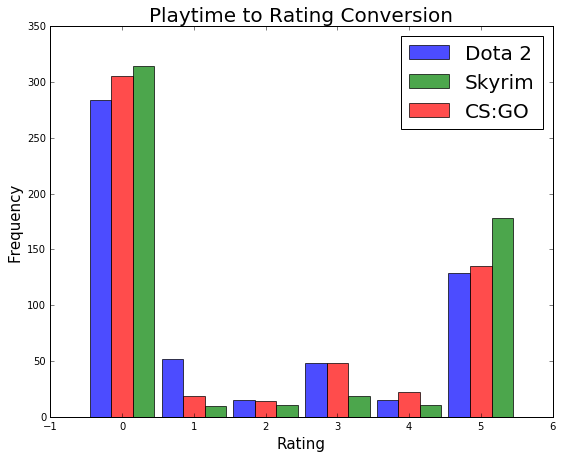

In [452]:
plt.figure(figsize=(9,7))
ax = plt.subplot(111)
ax.bar(np.array(dota2_vals.index)-0.3, dota2_vals.values, width=0.3, align="center", alpha=0.7, color='b', label="Dota 2")
ax.bar(np.array(skyrim_vals.index)+0.3, skyrim_vals.values, width=0.3, align="center", alpha=0.7, color='g', label="Skyrim")
ax.bar(csgo_vals.index, csgo_vals.values, width=0.3, align="center", alpha=0.7, color='r', label="CS:GO")
ax.legend(loc="upper right", prop={'size':20})
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Rating", fontsize=15)
plt.title("Playtime to Rating Conversion", fontsize=20)
plt.show()

# Attempted 

In [332]:
game_times.mean()

1977.449806949807

In [346]:
game_times = np.array([])
for game in pivoted:
    #print Pivoted.playtime_2weeks[game].sum()
    game_times = np.append(game_times, pivoted[game].sum())
print game_times.mean()

1977.44980695


In [280]:
Pivoted.playtime_2weeks[730].sum()/60.

1031.1333333333334

In [308]:
game_times.mean()

15227.731133113311

In [311]:
Pivoted.playtime_forever.columns[:10]

Int64Index([10, 20, 30, 40, 50, 60, 70, 80, 92, 100], dtype='int64', name=u'appid')

# Drop columns with with total playtime below average

In [348]:
for col in pivoted.columns:
    if pivoted[col].sum() <= 1977:
        pivoted.drop(col, axis=1, inplace=True)

In [337]:
#Pivoted.playtime_forever.drop(10, axis=1)
pivoted.head()[730]

uid
76561197976676146    1588
76561197980092471       0
76561197981918203     234
76561197993408842       0
76561197995295208       0
Name: 730.0, dtype: int64

In [125]:
sample.iloc[2].name

u'76561198042305043'

In [126]:
for i in xrange(len(sample)):
    #print i
    for g in sample.iloc[i]["game_info"]:
        #print len(g)
        #print g["name"], g["playtime_forever"], pub_games["steamid"][i]
        g["uid"] = sample.iloc[i].name
        #print pub_games["steamid"][i]
        #del g["appid"]
    #print game[0]

In [43]:
#few_games["game_info"][0]

[{u'name': u'Half-Life 2',
  u'playtime_2weeks': 0,
  u'playtime_forever': 63,
  'steamid': u'76561197981918203',
  'uid': u'76561197981918203'},
 {u'name': u'Counter-Strike: Source',
  u'playtime_2weeks': 0,
  u'playtime_forever': 72,
  'steamid': u'76561197981918203',
  'uid': u'76561197981918203'},
 {u'name': u'Half-Life: Source',
  u'playtime_2weeks': 0,
  u'playtime_forever': 0,
  'steamid': u'76561197981918203',
  'uid': u'76561197981918203'},
 {u'name': u'Half-Life 2: Deathmatch',
  u'playtime_2weeks': 0,
  u'playtime_forever': 0,
  'steamid': u'76561197981918203',
  'uid': u'76561197981918203'},
 {u'name': u'Half-Life 2: Lost Coast',
  u'playtime_2weeks': 0,
  u'playtime_forever': 25,
  'steamid': u'76561197981918203',
  'uid': u'76561197981918203'},
 {u'name': u'Half-Life Deathmatch: Source',
  u'playtime_2weeks': 0,
  u'playtime_forever': 0,
  'steamid': u'76561197981918203',
  'uid': u'76561197981918203'},
 {u'name': u'Half-Life 2: Episode One',
  u'playtime_2weeks': 0,
  u'

In [135]:
GameSeries = few_games["game_info"][1]
GameSeries2 = pd.DataFrame(few_games["game_info"][2])

In [115]:
SparseGames = pd.DataFrame(GameSeries)

In [177]:
SparseGames.head()

,appid,name,playtime_2weeks,playtime_forever,uid
0,NaN,Half-Life 2,0.0,2893.0,76561197971340950
1,NaN,Counter-Strike: Source,0.0,1711.0,76561197971340950
2,NaN,Half-Life 2: Deathmatch,0.0,2090.0,76561197971340950
3,NaN,Half-Life 2: Lost Coast,0.0,52.0,76561197971340950
4,NaN,Garry's Mod,43.0,26780.0,76561197971340950


In [125]:
for u in few_games["game_info"]:
    user_df = pd.DataFrame(u)
    SparseGames.append(user_df)

In [128]:
SparseGames = pd.DataFrame(columns=["name", "playtime_2weeks", "playtime_forever", "uid"])

In [129]:
#SparseGames = pd.D
for u in sample["game_info"]:
    Gamedf = pd.DataFrame(u)
    SparseGames = SparseGames.append(Gamedf)

,appid,name,playtime_2weeks,playtime_forever,uid
0,220.0,Half-Life 2,0.0,63.0,76561197981918203
1,240.0,Counter-Strike: Source,0.0,72.0,76561197981918203
2,280.0,Half-Life: Source,0.0,0.0,76561197981918203
3,320.0,Half-Life 2: Deathmatch,0.0,0.0,76561197981918203
4,340.0,Half-Life 2: Lost Coast,0.0,25.0,76561197981918203


In [169]:
#SparseGames = pd.DataFrame(columns=["name", "playtime_2weeks", "playtime_forever", "uid"])

In [52]:
del SparseGames["appid"]
del SparseGames["steamid"]

In [53]:
SparseGames.head()

,name,playtime_2weeks,playtime_forever,uid
0,Half-Life 2,0.0,63.0,76561197981918203
1,Counter-Strike: Source,0.0,72.0,76561197981918203
2,Half-Life: Source,0.0,0.0,76561197981918203
3,Half-Life 2: Deathmatch,0.0,0.0,76561197981918203
4,Half-Life 2: Lost Coast,0.0,25.0,76561197981918203


In [132]:
# df.pivot(index='date', columns='variable', values='value')
Pivoted = pd.pivot_table(SparseGames, index=uid, columns=["name"], values=["playtime_forever"], fill_value=0)

In [135]:
Pivoted

playtime_forever                \
name              A Virus Named TOM Ace of Spades   
uid                                                 
76561197976676146                 0             0   
76561197980092471                 0             0   
76561197981918203                 0             0   
76561197993408842                 0           104   
76561197995295208                 0             0   
76561198042305043                 0             0   
76561198050035478                 0             0   
76561198068277537                 0             0   
76561198129757415                 0             0   
76561198202663196                 0             0   

                                                 \
name              Age of Empires II: HD Edition   
uid                                               
76561197976676146                            33   
76561197980092471                             0   
76561197981918203                           256   
76561197993408842                             0   
76561197995295208                             0   
76561198042305043                             0   
76561198050035478                             0   
76561198068277537                             0   
76561198129757415                             0   
76561198202663196                             0   

                                                                      \
name              Age of Empires® III: Complete Collection Alan Wake   
uid                                                                    
76561197976676146                                        8         0   
76561197980092471                                        0        27   
76561197981918203                                        0         0   
76561197993408842                                        0         0   
76561197995295208                                        0         0   
76561198042305043                                        0         0   
76561198050035478                                        0         0   
76561198068277537                                        0         0   
76561198129757415                                        0         0   
76561198202663196                                        0         0   

                                                                               \
name              Alan Wake's American Nightmare Alien Swarm Alien: Isolation   
uid                                                                             
76561197976676146                              0        1810                0   
76561197980092471                              0         421                0   
76561197981918203                              0           0              384   
76561197993408842                              0           0                0   
76561197995295208                              0           0                0   
76561198042305043                              0           0                0   
76561198050035478                              0           0                0   
76561198068277537                              0           0                0   
76561198129757415                              0           0                0   
76561198202663196                              0           0                0   

                                                                       ...     \
name              Alpha Protocol Amazing Adventures Around the World   ...      
uid                                                                    ...      
76561197976676146              0                                   0   ...      
76561197980092471            141                                   0   ...      
76561197981918203              0                                   0   ...      
76561197993408842              0                                   0   ...      
76561197995295208              0                                   0   ...      
76561198042305043         